In [50]:
from pathlib import Path
from typing import List
import string

import functools
import operator 

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

from kedro.extras.datasets.pickle import PickleDataSet
from kedro.config import ConfigLoader

import kornia.augmentation as K

import monai
from monai.networks import one_hot
from scipy import ndimage

from skimage.draw import disk

import torch
from torch.utils.data import DataLoader, TensorDataset, random_split
from torchvision.utils import save_image

In [10]:
import os, sys
sys.path.append(os.path.abspath('..'))
sys.path.append(os.path.abspath('../src/'))

from src.tagseg.metrics.shape import ShapeDistLoss
from src.tagseg.metrics.dice import Dice

In [24]:
def losses(input, target, smooth_k):
    input = torch.Tensor(input).float().unsqueeze(0)
    target = torch.Tensor(target).long().unsqueeze(0).unsqueeze(0)

    sl = ShapeDistLoss(to_onehot_y=True, include_background=False, smooth_k=smooth_k)(input, target)
    cel = torch.nn.CrossEntropyLoss()(input, target[0])
    dice = monai.losses.DiceLoss(to_onehot_y=True, include_background=False)(input, target)

    return sl.item(), cel.item(), dice.item()

In [21]:
def distance_maps(target, smooth_k=1e-2):

        target = torch.Tensor(target).long().unsqueeze(0).unsqueeze(0)

        target = one_hot(target, 2)
        target = target[:, 1:]

        distance_maps = torch.Tensor()

        for _im in range(target.shape[0]):
            distance_map = torch.Tensor()

            for _class in range(target.shape[1]):
                roi = target[_im, _class].numpy()

                dt = ndimage.distance_transform_edt(roi)
                dt /= dt.max() + 1e-8
                dt_n = ndimage.distance_transform_edt(1 - roi)
                dt_n /= dt_n.max() + 1e-8

                shape_information = (1 - dt) #  * roi + (dt_n - 1) * (1 - roi)
                sdm = torch.Tensor(1 / (1 + np.exp(-shape_information / smooth_k))) * roi
                distance_map = torch.cat([distance_map, sdm.unsqueeze(0)], axis=0)

            distance_maps = torch.cat([distance_maps, distance_map.unsqueeze(0)], axis=0)

        distance_maps = distance_maps.to(target.device)

        return distance_maps

In [22]:
cases = []

input = np.zeros((256, 256))
input[disk((128, 128), 64)] = 1
input[disk((128, 128), 32)] = 0
input = np.array([1 - input, input])

target = np.zeros((256, 256))
target[disk((128, 128), 64)] = 1
target[disk((128, 128), 32)] = 0

cases.append(dict(input=input, target=target))

input = np.zeros((256, 256))
input[disk((128, 128), 86)] = 1
input[disk((128, 128), 16)] = 0
input = np.array([1 - input, input])

target = np.zeros((256, 256))
target[disk((128, 128), 64)] = 1
target[disk((128, 128), 32)] = 0

cases.append(dict(input=input, target=target))

input = np.zeros((256, 256))
input[disk((128, 128), 64)] = 1
input[disk((128, 128), 32)] = 0
input = np.array([1 - input, input])

target = np.zeros((256, 256))
target[disk((128, 128), 86)] = 1
target[disk((128, 128), 16)] = 0

cases.append(dict(input=input, target=target))

input = np.zeros((256, 256))
input[disk((180, 180), 64)] = 1
input[disk((180, 180), 32)] = 0
input = np.array([1 - input, input])

target = np.zeros((256, 256))
target[disk((90, 90), 64)] = 1
target[disk((90, 90), 32)] = 0

cases.append(dict(input=input, target=target))

input = np.zeros((256, 256))
input[disk((132, 128), 64)] = 1
input[disk((132, 128), 32)] = 0
input = np.array([1 - input, input])

target = np.zeros((256, 256))
target[disk((112, 128), 64)] = 1
target[disk((112, 128), 32)] = 0

cases.append(dict(input=input, target=target))

/tmp/ipykernel_12121/3508779976.py:47: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


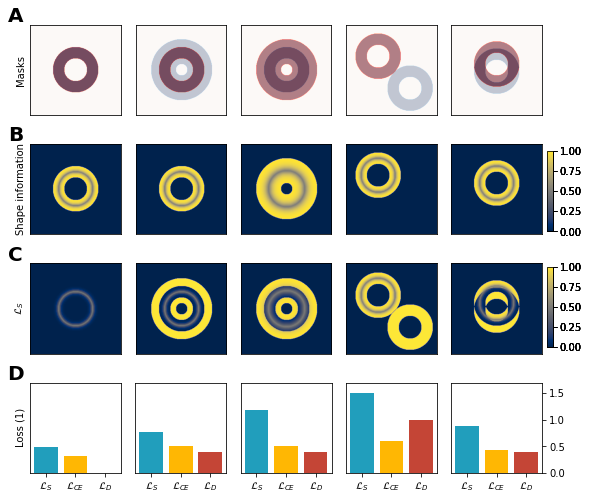

In [59]:
plt.rcParams['ytick.right'] = plt.rcParams['ytick.labelright'] = True
plt.rcParams['ytick.left'] = plt.rcParams['ytick.labelleft'] = False

fig, ax = plt.subplots(4, len(cases), figsize=(8, 7))

for i, case in enumerate(cases):

    ax[0, i].imshow(case['input'][1], cmap='Blues', alpha=0.5)
    ax[0, i].imshow(case['target'], cmap='Reds', alpha=0.5)
    ax[0, i].set_xticks([]), ax[0, i].set_yticks([])


    dm = distance_maps(case['target'], smooth_k=.2)
    im = ax[1, i].imshow(dm[0, 0], cmap='cividis', vmin=0., vmax=1.)
    ax[1, i].set_xticks([]), ax[1, i].set_yticks([])

    # if i == len(cases) - 1:
        # divider = make_axes_locatable(ax[1, i])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=fig.add_axes([0.95, 0.54, 0.01, 0.16]))

    diff = (torch.Tensor(case['input']).unsqueeze(0)[:, 1:] - dm).abs()
    im = ax[2, i].imshow(diff[0, 0], cmap='cividis', vmin=0., vmax=1.)
    ax[2, i].set_xticks([]), ax[2, i].set_yticks([])

    # if i == len(cases) - 1:
        # divider = make_axes_locatable(ax[2, i])
        # cax = divider.append_axes('right', size='5%', pad=0.05)
    plt.colorbar(im, cax=fig.add_axes([0.95, 0.31, 0.01, 0.16]))

    loss_names = [r'$\mathcal{L}_S$', r'$\mathcal{L}_{CE}$', r'$\mathcal{L}_D$']
    loss_values = list(losses(case['input'], case['target'], smooth_k=10))
    ax[3, i].bar(loss_names, loss_values, color=['#219EBC', '#FFB703', '#C44536'])
    ax[3, i].set_ylim(0, 1.7)
    if i < len(cases) - 1:
        ax[3, i].set_yticks([])

ax[0, 0].set_ylabel('Masks')
ax[1, 0].set_ylabel('Shape information')
ax[2, 0].set_ylabel(r'$\mathcal{L}_S$')
ax[3, 0].set_ylabel('Loss (1)')

for row in range(4):
    axes = ax[row, 0]
    axes.text(-.25, 1.03, string.ascii_uppercase[row], transform=axes.transAxes, size=20, weight='bold')

plt.tight_layout()

In [60]:
fig.savefig('../../figures/shape-loss.pdf', bbox_inches='tight')

/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1721: DeprecationWarning: NONE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.NEAREST or Dither.NONE instead.
  img = img.convert(mode='P', dither=Image.NONE,
/opt/conda/envs/tagseg/lib/python3.8/site-packages/matplotlib/backends/backend_pdf.py:1722: DeprecationWarning: ADAPTIVE is deprecated and will be removed in Pillow 10 (2023-07-01). Use Palette.ADAPTIVE instead.
  palette=Image.ADAPTIVE, colors=num_colors)
